# Goals:
* Connect to database 
* Query the table in database
* Explore the data
* Analyzing and Visualizing the data
* Customer Segmentation (RFM value and RFM customer segmentation

### Loading the necessary libraries

In [1]:
# import the libraries needed
import os
import sys
import pandas as pd
import datetime as dt
import psycopg2
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors
import plotly.io as pio
from matplotlib import pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.extract import connect_to_redshift

# using this library for reading password
from dotenv import load_dotenv
load_dotenv()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import variables from .env file
dbname = os.getenv("dbname")
host = os.getenv("host")
port = os.getenv("port")
user = os.getenv("user")
password = os.getenv("password")
aws_access_key_id = os.getenv("aws_access_key_id")
aws_secret_access_key_id = os.getenv("aws_secret_access_key_id")

In [3]:
connect = connect_to_redshift(dbname, host, port, user, password)

connection to redshift made


### Exracting the data by SOL query

In [4]:
query= """select * 
          from bootcamp.online_transactions_cleaned          
       """ 

online_trans_cleaned = pd.read_sql(query, connect)

In [5]:
online_trans_cleaned.head(5)

invoice stock_code                       description  price  quantity   
0  536381     37444A   YELLOW BREAKFAST CUP AND SAUCER   2.95         1  \
1  536384      22189           CREAM HEART CARD HOLDER   3.95         4   
2  536390      22960          JAM MAKING SET WITH JARS   3.75        12   
3  536392      21891  TRADITIONAL WOODEN SKIPPING ROPE   1.25        12   
4  536396     82494L       WOODEN FRAME ANTIQUE WHITE    2.55        12   

   total_order_value        invoice_date customer_id         country  
0               2.95 2010-12-01 09:41:00      u15311  United Kingdom  
1              15.80 2010-12-01 09:53:00      u18074  United Kingdom  
2              45.00 2010-12-01 10:19:00      u17511  United Kingdom  
3              15.00 2010-12-01 10:29:00      u13705  United Kingdom  
4              30.60 2010-12-01 10:51:00       u1785  United Kingdom

In [6]:
online_trans_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399841 entries, 0 to 399840
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   invoice            399841 non-null  object        
 1   stock_code         399841 non-null  object        
 2   description        399841 non-null  object        
 3   price              399841 non-null  float64       
 4   quantity           399841 non-null  int64         
 5   total_order_value  399841 non-null  float64       
 6   invoice_date       399841 non-null  datetime64[ns]
 7   customer_id        399841 non-null  object        
 8   country            399841 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 27.5+ MB


In [7]:
# Let's start with some basic exploratory data analysis

print("No. of unique invoices:", len(online_trans_cleaned.invoice.unique()))
print("No. of unique Stock Codes:", len(online_trans_cleaned.stock_code.unique()))
print("No. of unique Discription:", len(online_trans_cleaned.description.unique()))
print("No. of unique Customers ID:", len(online_trans_cleaned.customer_id.unique()))
print("No. of unique Geographical Locations:", len(online_trans_cleaned.country.unique()))

print("\n The most expensive product Price:", online_trans_cleaned.price.max())
print("The average price of a Product:", round(online_trans_cleaned.price.mean(), 2))
print("Total Products sold:", (online_trans_cleaned.quantity.sum()))

No. of unique invoices: 21791
No. of unique Stock Codes: 3679
No. of unique Discription: 3644
No. of unique Customers ID: 4363
No. of unique Geographical Locations: 37

 The most expensive product Price: 1599.26
The average price of a Product: 2.95
Total Products sold: 4887800


In [8]:
online_trans_cleaned.country.value_counts()

country
United Kingdom          356158
Germany                   9081
France                    8154
EIRE                      7469
Spain                     2463
Netherlands               2330
Belgium                   1971
Switzerland               1844
Portugal                  1427
Australia                 1256
Norway                    1060
Italy                      783
Channel Islands            755
Finland                    653
Cyprus                     608
Sweden                     436
Austria                    387
Denmark                    375
Japan                      355
Poland                     336
USA                        291
Israel                     247
Unspecified                241
Singapore                  215
Iceland                    182
Canada                     150
Greece                     142
Malta                      123
United Arab Emirates        67
European Community          58
RSA                         57
Lebanon                     45


## Analyze and Visualize the Data


In [9]:
customer_spend = online_trans_cleaned.groupby(['customer_id', 'country'])['total_order_value'].sum().sort_values(ascending=False).reset_index(name='total_spend').head(10)

In [10]:
print(customer_spend)

  customer_id         country  total_spend
0      u14646     Netherlands    278778.02
1      u18102  United Kingdom    259657.30
2       u1745  United Kingdom    189575.53
3      u14911            EIRE    132893.24
4      u12415       Australia    123638.18
5      u14156            EIRE    114335.77
6      u17511  United Kingdom     88138.20
7      u16684  United Kingdom     65920.12
8      u14096  United Kingdom     65164.79
9      u13694  United Kingdom     62961.54


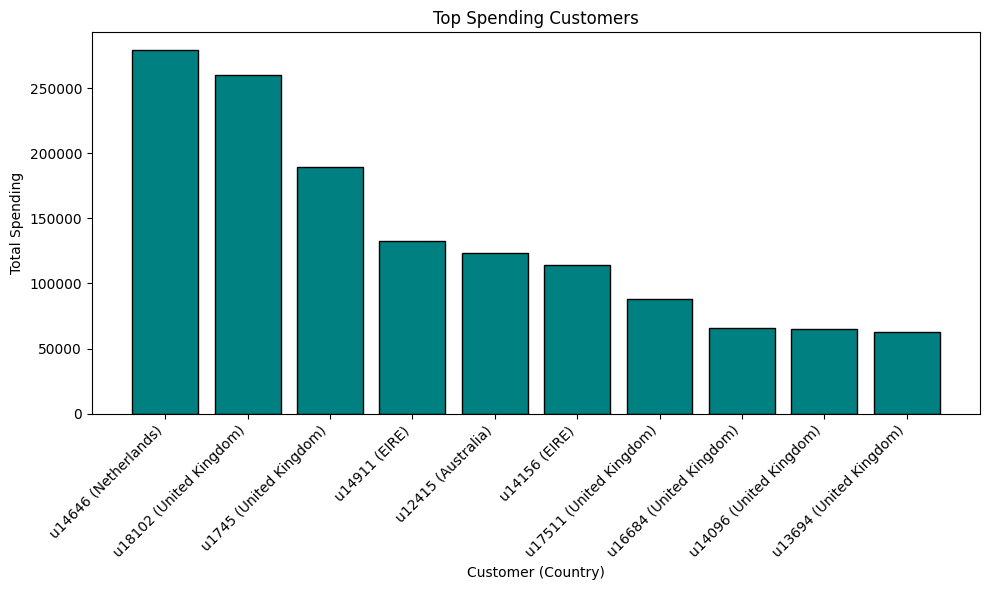

In [11]:

# Plotting the top spending customers
plt.figure(figsize=(10, 6))
plt.bar(customer_spend.index, customer_spend['total_spend'], edgecolor='black', color='teal')
plt.xlabel('Customer (Country)')
plt.ylabel('Total Spending')
plt.title('Top Spending Customers')
plt.xticks(customer_spend.index, customer_spend['customer_id'] + ' (' + customer_spend['country'] + ')', rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### 1. What are the top ten most popular geographical locations?

In [12]:
# Based on number of transaction
# Group the data by country and count the number of transactions
transactions_per_country = online_trans_cleaned['country'].value_counts()

In [13]:
# Get the top ten most popular geographical locations
top_ten_geo_locations = transactions_per_country.head(10)
top_ten_geo_locations 

country
United Kingdom    356158
Germany             9081
France              8154
EIRE                7469
Spain               2463
Netherlands         2330
Belgium             1971
Switzerland         1844
Portugal            1427
Australia           1256
Name: count, dtype: int64

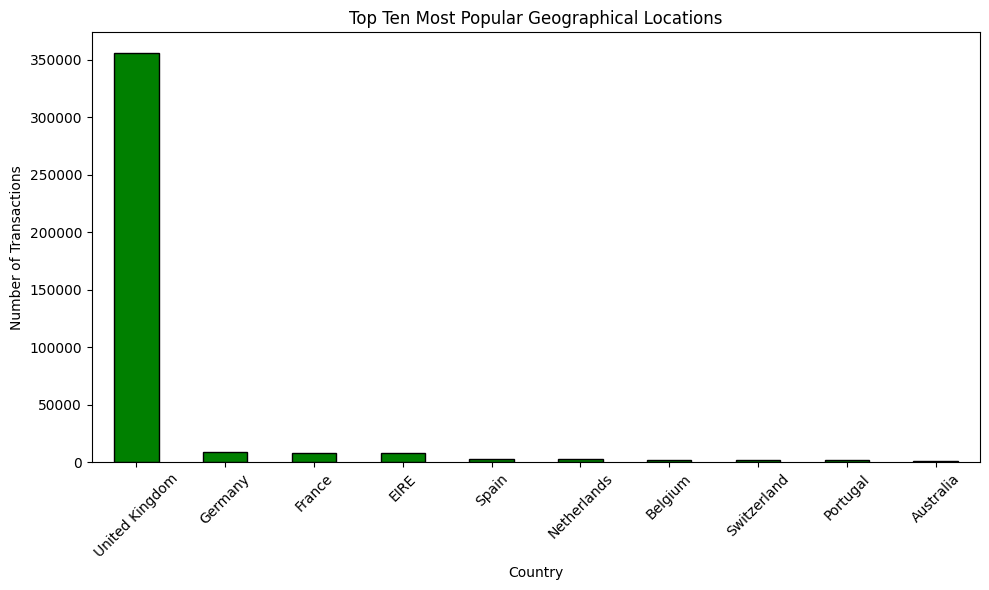

In [14]:
# Create a bar plot
plt.figure(figsize=(10, 6))
bar_color = 'green'
top_ten_geo_locations.plot(kind='bar', edgecolor='black', color=bar_color)
plt.title('Top Ten Most Popular Geographical Locations')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

#### 2. Which country spends the most (you can look at price, quantity or order value i.e. price * quantity)?

In [15]:
# Based on order value
grouped_data = online_trans_cleaned.groupby('country')['total_order_value'].sum().sort_values()

In [16]:
country_spending_most = grouped_data.sort_values(ascending=False).head(10)
print(country_spending_most)

country
United Kingdom    6815375.093
Netherlands        283479.540
EIRE               251557.470
Germany            200619.660
France             181571.540
Australia          136922.500
Switzerland         51859.400
Spain               51746.650
Belgium             36662.960
Japan               35419.790
Name: total_order_value, dtype: float64


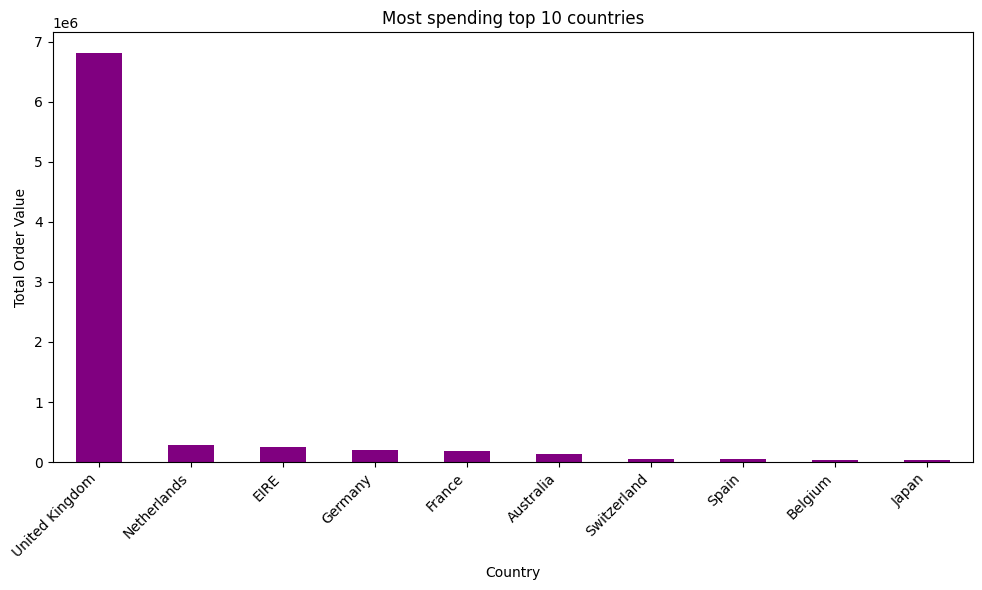

In [17]:
# Create a bar chart to visualize the top ten locations
plt.figure(figsize=(10, 6))
bar_color = 'purple'
country_spending_most.sort_values(ascending=False).plot(kind='bar', color=bar_color)
plt.xlabel('Country')
plt.ylabel('Total Order Value')
plt.title('Most spending top 10 countries')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
# Based on number of transaction

In [19]:
# Group the data by 'country' and count the unique invoices (transactions)
country_transactions = online_trans_cleaned.groupby('country')['invoice'].nunique()

# Get the top 10 countries with the highest number of transactions
top_10_countries = country_transactions.sort_values(ascending=False).head(10)

print("Top 10 countries based on number of transactions:")
print(top_10_countries)

Top 10 countries based on number of transactions:
country
United Kingdom    19583
Germany             578
France              439
EIRE                313
Belgium             117
Spain               100
Netherlands          97
Australia            67
Switzerland          65
Portugal             55
Name: invoice, dtype: int64


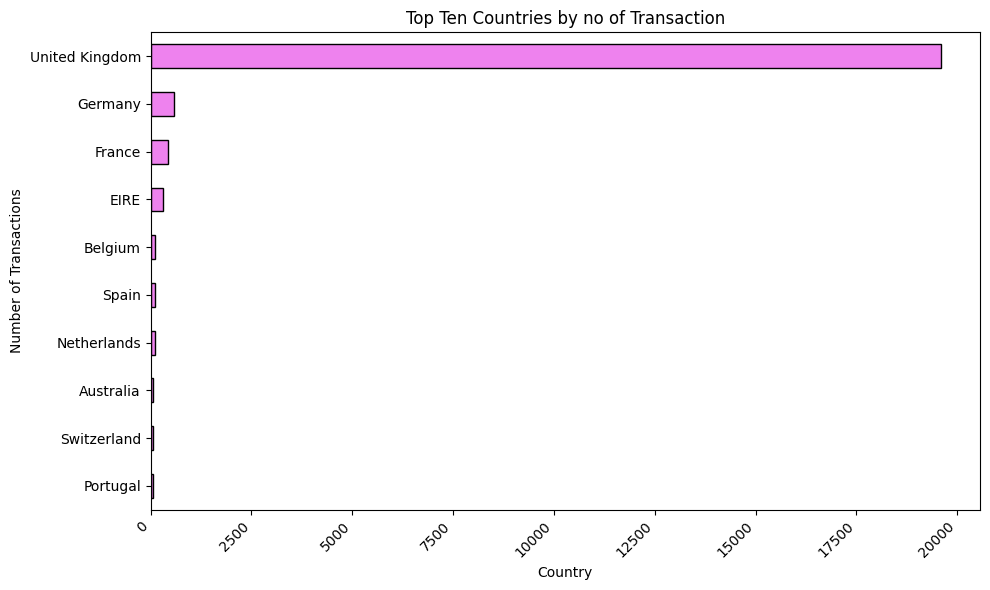

In [20]:
# Create a bar chart to visualize the top ten locations
plt.figure(figsize=(10, 6))
bar_color = 'violet'
top_10_countries.sort_values(ascending=True).plot(kind='barh',edgecolor='black', color=bar_color)
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.title('Top Ten Countries by no of Transaction')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

* Based on transaction volume, the United Kingdom emerges as the leading country, followed by Germany, France, and EIRE. These countries demonstrate the highest frequency of transactions within the observed dataset.

 However, when considering expenditure in terms of total order value – calculated by the product of quantity and price – the     United Kingdom remains at the forefront, with Netherlands, EIRE, and Germany sequentially following suit. This analysis     highlights that while the United Kingdom holds the position of highest transaction frequency, it also retains its dominance in terms of overall spending, with Netherlands, EIRE, and Germany contributing significantly to the total order value.

In essence, the transaction landscape is characterized by the United Kingdom's preeminence both in terms of transaction count and total order value, while other nations such as the Netherlands, EIRE, and Germany also play crucial roles in driving substantial order value.

In [21]:
# Top most popular products
top_selling_items = online_trans_cleaned.groupby(['stock_code', 'description'])['quantity'].sum().reset_index()
top_selling_items = top_selling_items.sort_values(by='quantity', ascending=False).head(10)

print("Top Ten Best-Selling Items:")
print(top_selling_items)


Top Ten Best-Selling Items:
     stock_code                         description  quantity
2812      84077   WORLD WAR 2 GLIDERS ASSTD DESIGNS     53119
1092      22197                      POPCORN HOLDER     48689
3235     85099B             JUMBO BAG RED RETROSPOT     44963
3069      84879       ASSORTED COLOUR BIRD ORNAMENT     35215
3249     85123A  CREAM HANGING HEART T-LIGHT HOLDER     34185
425       21212     PACK OF 72 RETROSPOT CAKE CASES     33386
1923      23084                  RABBIT NIGHT LIGHT     27045
1356      22492             MINI PAINT SET VINTAGE      25880
1473      22616          PACK OF 12 LONDON TISSUES      25305
914       21977  PACK OF 60 PINK PAISLEY CAKE CASES     24129


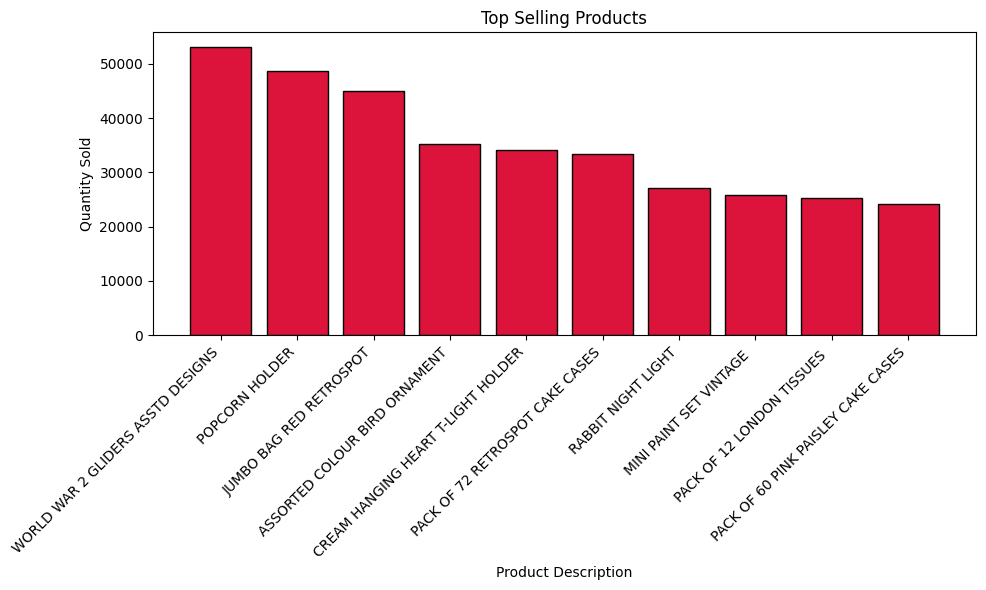

In [22]:
import matplotlib.pyplot as plt

# Plotting the top selling products
plt.figure(figsize=(10, 6))
plt.bar(top_selling_items['description'], top_selling_items['quantity'], edgecolor='black', color='crimson')
plt.ylabel('Quantity Sold')
plt.xlabel('Product Description')
plt.title('Top Selling Products')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


#### 3.You could look at seasonality
* a. Visualize the distribution of Invoices per month?       
* b. Which month has the highest number of transactions?
* c. Which day of the week has the highest number of transactions?


In [23]:
# a. Visualize the distribution of Invoices per month?
# Convert 'invoice_date' column to datetime format
online_trans_cleaned['invoice_date'] = pd.to_datetime(online_trans_cleaned['invoice_date'])

In [24]:
# Extract year and month from the 'invoice_date' column
online_trans_cleaned['year'] = online_trans_cleaned['invoice_date'].dt.year
online_trans_cleaned['month'] = online_trans_cleaned['invoice_date'].dt.month

In [25]:
# Group data by year and month, and count the number of unique invoices
invoices_per_month = online_trans_cleaned.groupby(['year', 'month'])['invoice'].nunique()
invoices_per_month

year  month
2010  12       1692
2011  1        1225
      2        1181
      3        1588
      4        1358
      5        1808
      6        1686
      7        1555
      8        1506
      9        2038
      10       2208
      11       3034
      12        912
Name: invoice, dtype: int64

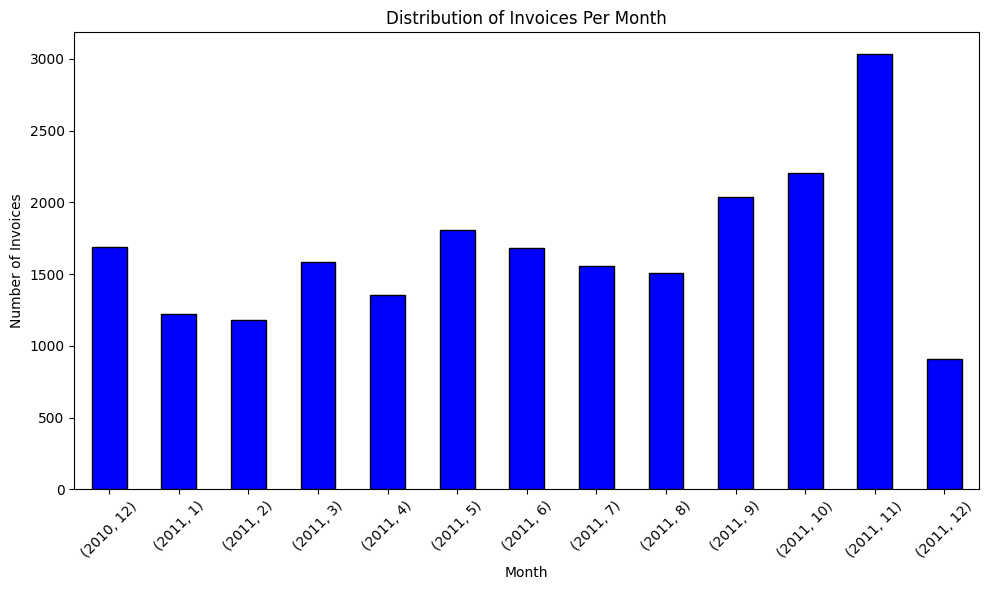

In [26]:
# Create a line plot for the distribution of invoices per month
plt.figure(figsize=(10, 6))
bar_color ='blue'
invoices_per_month.plot(kind='bar', edgecolor='black', color=bar_color)
plt.title('Distribution of Invoices Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Invoices')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [27]:
# Which month has the highest number of transactions?
# Group data by month and count the number of transactions
transactions_per_month = online_trans_cleaned.groupby('month')['invoice'].nunique()
transactions_per_month

month
1     1225
2     1181
3     1588
4     1358
5     1808
6     1686
7     1555
8     1506
9     2038
10    2208
11    3034
12    2604
Name: invoice, dtype: int64

In [28]:
# Find the month with the highest number of transactions
highest_month = transactions_per_month.idxmax()
highest_transactions = transactions_per_month.max()

In [29]:
print(f"The month with the highest number of transactions is {highest_month} with {highest_transactions} transactions.")

The month with the highest number of transactions is 11 with 3034 transactions.


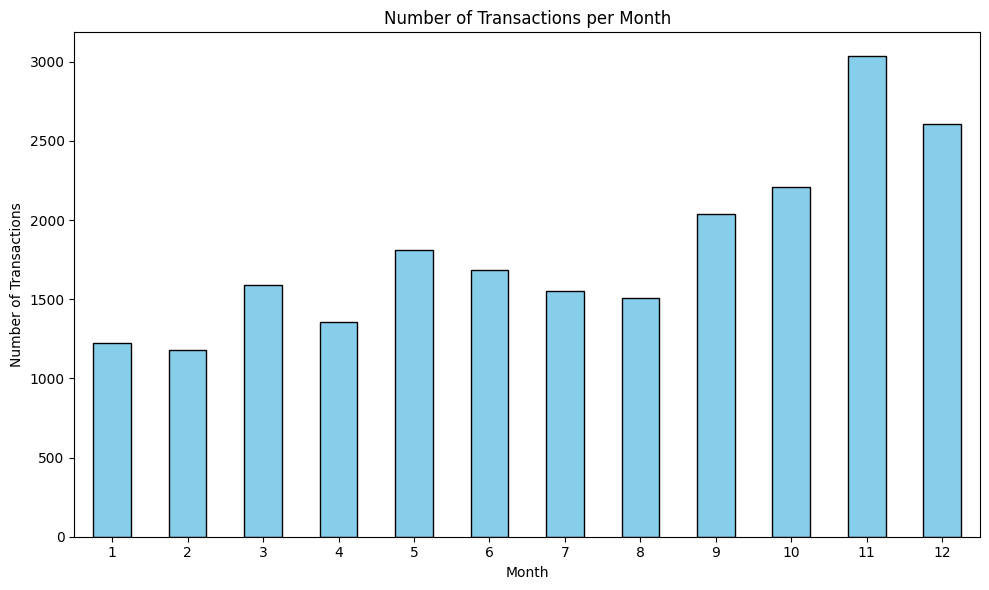

In [30]:
# Distribution of transaction per month
# Plotting the number of transactions per month
plt.figure(figsize=(10, 6))
transactions_per_month.plot(kind='bar', edgecolor='black', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions per Month')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.tight_layout()
plt.show()


In [31]:
# c. Which day of the week has the highest number of transactions?

In [32]:
# Extract the day of the week (0=Monday, 6=Sunday) from the 'invoice_date' column
online_trans_cleaned['day_of_week'] = online_trans_cleaned['invoice_date'].dt.dayofweek

# Define day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Add 'day_name' column to the DataFrame
online_trans_cleaned['day_name'] = [day_names[day] for day in online_trans_cleaned['day_of_week']]
online_trans_cleaned

invoice stock_code                          description  price   
0       536381     37444A      YELLOW BREAKFAST CUP AND SAUCER   2.95  \
1       536384      22189              CREAM HEART CARD HOLDER   3.95   
2       536390      22960             JAM MAKING SET WITH JARS   3.75   
3       536392      21891     TRADITIONAL WOODEN SKIPPING ROPE   1.25   
4       536396     82494L          WOODEN FRAME ANTIQUE WHITE    2.55   
...        ...        ...                                  ...    ...   
399836  581495      21523   DOORMAT FANCY FONT HOME SWEET HOME   7.08   
399837  581514      22645  CERAMIC HEART FAIRY CAKE MONEY BANK   0.39   
399838  581538      22197                       POPCORN HOLDER   0.85   
399839  581578      21122   SET/10 PINK POLKADOT PARTY CANDLES   1.25   
399840  581585      23356                LOVE HOT WATER BOTTLE   5.95   

        quantity  total_order_value        invoice_date customer_id   
0              1               2.95 2010-12-01 09:41:00      u15311  \
1              4              15.80 2010-12-01 09:53:00      u18074   
2             12              45.00 2010-12-01 10:19:00      u17511   
3             12              15.00 2010-12-01 10:29:00      u13705   
4             12              30.60 2010-12-01 10:51:00       u1785   
...          ...                ...                 ...         ...   
399836        10              70.80 2011-12-09 10:20:00      u14051   
399837         4               1.56 2011-12-09 11:20:00      u17754   
399838         4               3.40 2011-12-09 11:34:00      u14446   
399839        24              30.00 2011-12-09 12:16:00      u12713   
399840         3              17.85 2011-12-09 12:31:00      u15804   

               country  year  month  day_of_week   day_name  
0       United Kingdom  2010     12            2  Wednesday  
1       United Kingdom  2010     12            2  Wednesday  
2       United Kingdom  2010     12            2  Wednesday  
3       United Kingdom  2010     12            2  Wednesday  
4       United Kingdom  2010     12            2  Wednesday  
...                ...   ...    ...          ...        ...  
399836  United Kingdom  2011     12            4     Friday  
399837  United Kingdom  2011     12            4     Friday  
399838  United Kingdom  2011     12            4     Friday  
399839         Germany  2011     12            4     Friday  
399840  United Kingdom  2011     12            4     Friday  

[399841 rows x 13 columns]

In [33]:
# Group data by day of the week and count the number of transactions
transactions_per_day = online_trans_cleaned.groupby('day_name')['invoice'].nunique()
transactions_per_day

day_name
Friday       3294
Monday       3418
Sunday       2334
Thursday     4888
Tuesday      3812
Wednesday    4045
Name: invoice, dtype: int64

In [34]:
# Find the day with the highest number of transactions
highest_day = transactions_per_day.idxmax()
highest_transactions = transactions_per_day.max()

print(f"The day with the highest number of transactions is {highest_day} with {highest_transactions} transactions.")

The day with the highest number of transactions is Thursday with 4888 transactions.


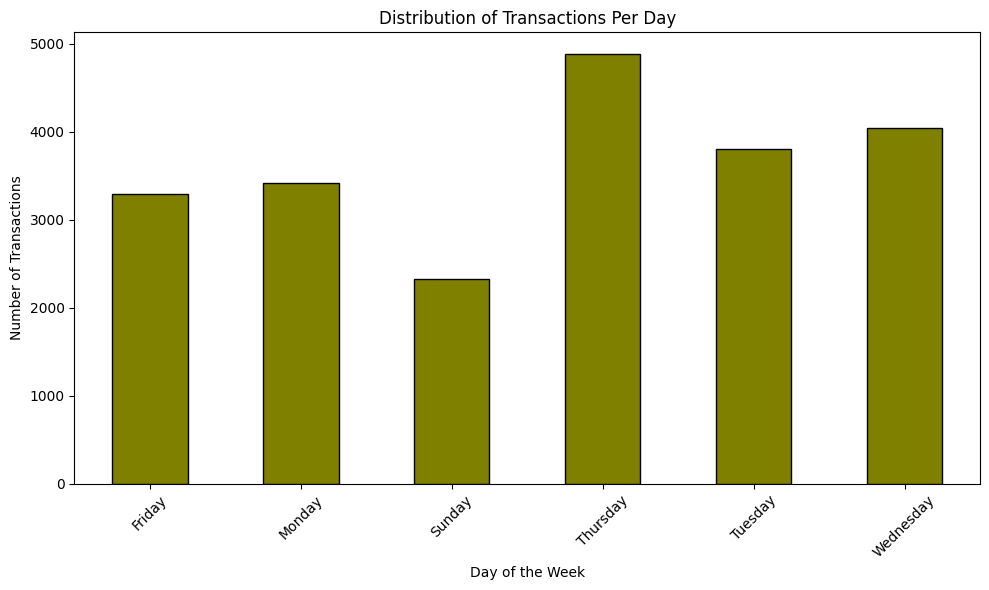

In [35]:
# Create a bar graph for the distribution of transactions per day
plt.figure(figsize=(10, 6))
transactions_per_day.plot(kind='bar', edgecolor='black', color='olive')
plt.title('Distribution of Transactions Per Day')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [36]:
# To find out which invoice did maximum transactons in DOW
# Extract DOW_transaction using groupby as per invoices

day_transaction=online_trans_cleaned.groupby('invoice')['day_of_week'].sum().sort_values(ascending=False).reset_index(name= 'day_transaction')
day_transaction

invoice  day_transaction
0      567183             2346
1      547063             1686
2      554098             1536
3      566290             1242
4      556484             1194
...       ...              ...
21786  558892                0
21787  542736                0
21788  542737                0
21789  542739                0
21790  566440                0

[21791 rows x 2 columns]

In [37]:
# To find out customer_id & country alongwith invoices spend most DOW transaction in year
# Flitering areas where invocie.year = 2011
online_trans_cleaned.groupby(['customer_id','invoice','country'])['invoice_date'].value_counts().sort_values(ascending=False).reset_index(name='day_of_week_spend')

customer_id  invoice         country        invoice_date   
0          u14096   576339  United Kingdom 2011-11-14 15:27:00  \
1          u14096   579196  United Kingdom 2011-11-28 15:54:00   
2          u14096   580727  United Kingdom 2011-12-05 17:17:00   
3          u14096   578270  United Kingdom 2011-11-23 13:39:00   
4          u14096   573576  United Kingdom 2011-10-31 14:09:00   
...           ...      ...             ...                 ...   
21817      u15764   564354  United Kingdom 2011-08-24 15:09:00   
21818      u14145  C561810  United Kingdom 2011-07-29 15:12:00   
21819      u17677   537228  United Kingdom 2010-12-06 08:43:00   
21820      u17677   537229  United Kingdom 2010-12-06 08:44:00   
21821      u12346   541431  United Kingdom 2011-01-18 10:01:00   

       day_of_week_spend  
0                    542  
1                    533  
2                    529  
3                    442  
4                    435  
...                  ...  
21817                  1  
21818                  1  
21819                  1  
21820                  1  
21821                  1  

[21822 rows x 5 columns]

In [38]:
online_trans_cleaned.columns

Index(['invoice', 'stock_code', 'description', 'price', 'quantity',
       'total_order_value', 'invoice_date', 'customer_id', 'country', 'year',
       'month', 'day_of_week', 'day_name'],
      dtype='object')

In [39]:
# To crosscheck invoice = 576339 has made 533 transactions in year 2011
online_trans_cleaned[(online_trans_cleaned.invoice == "576339")]

invoice stock_code                          description  price   
212429  576339     16258A       SWIRLY CIRCULAR RUBBERS IN BAG   0.83  \
212430  576339      21390        FILIGRIS HEART WITH BUTTERFLY   2.46   
212431  576339      21977   PACK OF 60 PINK PAISLEY CAKE CASES   1.25   
212432  576339      22367      CHILDRENS APRON SPACEBOY DESIGN   4.13   
212433  576339      22645  CERAMIC HEART FAIRY CAKE MONEY BANK   3.29   
...        ...        ...                                  ...    ...   
397121  576339      22107                   PIZZA PLATE IN BOX   3.29   
397122  576339      22467                    GUMBALL COAT RACK   4.96   
397123  576339      37500          TEA TIME TEAPOT IN GIFT BOX   8.29   
397124  576339     84970S    HANGING HEART ZINC T-LIGHT HOLDER   2.08   
397125  576339      85104             SILVER GLASS T-LIGHT SET   5.79   

        quantity  total_order_value        invoice_date customer_id   
212429         1               0.83 2011-11-14 15:27:00      u14096  \
212430         2               4.92 2011-11-14 15:27:00      u14096   
212431         5               6.25 2011-11-14 15:27:00      u14096   
212432         3              12.39 2011-11-14 15:27:00      u14096   
212433         3               9.87 2011-11-14 15:27:00      u14096   
...          ...                ...                 ...         ...   
397121         4              13.16 2011-11-14 15:27:00      u14096   
397122         1               4.96 2011-11-14 15:27:00      u14096   
397123         4              33.16 2011-11-14 15:27:00      u14096   
397124        15              31.20 2011-11-14 15:27:00      u14096   
397125         1               5.79 2011-11-14 15:27:00      u14096   

               country  year  month  day_of_week day_name  
212429  United Kingdom  2011     11            0   Monday  
212430  United Kingdom  2011     11            0   Monday  
212431  United Kingdom  2011     11            0   Monday  
212432  United Kingdom  2011     11            0   Monday  
212433  United Kingdom  2011     11            0   Monday  
...                ...   ...    ...          ...      ...  
397121  United Kingdom  2011     11            0   Monday  
397122  United Kingdom  2011     11            0   Monday  
397123  United Kingdom  2011     11            0   Monday  
397124  United Kingdom  2011     11            0   Monday  
397125  United Kingdom  2011     11            0   Monday  

[542 rows x 13 columns]

#### 4. Which customers could be considered high profile customers?
* a. Calculate an order value field, this is the price * quantity.
     Identify customers that have spent more than the average user.
* b. Which customers have purchased the most (look at the frequency of orders)?
* c. Can you say anything about customers that purchased recently?

   


In [40]:
# Define a spending threshold for high-profile customers
spending_threshold = 1000  # Adjust this threshold as needed

# Calculate total spending for each customer
customer_spending = online_trans_cleaned.groupby(['customer_id','country'])['total_order_value'].sum().nlargest(10)

# Identify high-profile customers based on spending threshold
high_profile_customers = customer_spending[customer_spending > spending_threshold]

# Print the list of high-profile customers
print("High-Profile Customers:")
print(high_profile_customers)


High-Profile Customers:
customer_id  country       
u14646       Netherlands       278778.02
u18102       United Kingdom    259657.30
u1745        United Kingdom    189575.53
u14911       EIRE              132893.24
u12415       Australia         123638.18
u14156       EIRE              114335.77
u17511       United Kingdom     88138.20
u16684       United Kingdom     65920.12
u14096       United Kingdom     65164.79
u13694       United Kingdom     62961.54
Name: total_order_value, dtype: float64


In [41]:
# Group data by 'customer_id' and calculate relevant metrics
# For each customer, caculate two metrics: 
# 'total_order_value':The sum of all the order values the customer made.
# 'invoice': The number of unique invoices the customer has.

customer_metrics = online_trans_cleaned.groupby('customer_id').agg({'total_order_value': 'sum','invoice': 'nunique'})
top_customers = customer_metrics.nlargest(10, 'total_order_value')
top_customers

total_order_value  invoice
customer_id                            
u14646               278778.02       74
u18102               259657.30       60
u1745                189575.53       49
u14911               132893.24      243
u12415               123638.18       24
u14156               114335.77       65
u17511                88138.20       45
u16684                65920.12       30
u14096                65164.79       17
u13694                62961.54       57

In [42]:
# Defining criteria for high-profile customers
# Total order value should be greater than or equal to $1000.
# The number of unique invoices (transactions) should be greater than or equal to 5.
high_profile_criteria = (
    (customer_metrics['total_order_value'] >= 1000) &  # Total spending criterion
    (customer_metrics['invoice'] >= 5)  # Frequency of purchases criterion
)
high_profile_criteria

customer_id
u12346    False
u12347     True
u12348    False
u12349    False
u1235     False
          ...  
u1828     False
u18281    False
u18282    False
u18283     True
u18287    False
Length: 4363, dtype: bool

In [43]:
# Identify high-profile customers based on the criteria
# 'high_profile_customers' that contains only the customers who meet the high-profile criteria.
# This DataFrame will only have rows for customers who are considered high-profile.

high_profile_customers = customer_metrics[high_profile_criteria]
high_profile_customers

total_order_value  invoice
customer_id                            
u12347                 4310.00        7
u12352                 1265.41        8
u12359                 6182.98        6
u12362                 4665.58       13
u1238                  2423.56        5
...                        ...      ...
u18245                 2507.56        8
u18257                 2274.03       11
u1826                  2580.15        8
u18272                 3064.78        7
u18283                 2039.58       16

[1158 rows x 2 columns]

In [44]:
# Print or analyze the list of high-profile customers
print("High-Profile Customers:")
print(high_profile_customers)

High-Profile Customers:
             total_order_value  invoice
customer_id                            
u12347                 4310.00        7
u12352                 1265.41        8
u12359                 6182.98        6
u12362                 4665.58       13
u1238                  2423.56        5
...                        ...      ...
u18245                 2507.56        8
u18257                 2274.03       11
u1826                  2580.15        8
u18272                 3064.78        7
u18283                 2039.58       16

[1158 rows x 2 columns]


###### a. Calculate an order value field, this is the price * quantity. Identify customers that have spent more than the average user.

In [45]:
# Calculate the average order value per customer
avg_order_per_customer = online_trans_cleaned.groupby('customer_id')['total_order_value'].mean()
avg_order_per_customer

customer_id
u12346     0.000000
u12347    23.681319
u12348    53.231111
u12349    20.243750
u1235     18.400000
            ...    
u1828     18.060000
u18281    11.545714
u18282    13.584615
u18283     2.836690
u18287    26.246857
Name: total_order_value, Length: 4363, dtype: float64

In [46]:
# Find the overall average order value across all customers
overall_avg_order = online_trans_cleaned['total_order_value'].mean()
overall_avg_order

20.71690357667173

In [47]:
# Identify customers who have spent more than the average user
above_avg_spending_customers = avg_order_per_customer[avg_order_per_customer > overall_avg_order]

print("High-Spending Customers:")
print(above_avg_spending_customers)
# Total no. customers spending above average are 1363

High-Spending Customers:
customer_id
u12347     23.681319
u12348     53.231111
u12353     22.250000
u12355     35.338462
u12356     42.886724
             ...    
u18246    149.025000
u18251    269.670000
u18259     55.680952
u18273     68.000000
u18287     26.246857
Name: total_order_value, Length: 1363, dtype: float64


##### b. Which customers have purchased the most (look at the frequency of orders)?

In [48]:
# Group data by 'customer_id' and count the number of unique invoices
customer_order_frequency = online_trans_cleaned.groupby('customer_id')['total_order_value'].nunique().nlargest(10)
customer_order_frequency

customer_id
u14911    481
u12748    395
u17841    377
u14646    362
u14156    347
u14088    331
u15311    331
u14096    304
u14298    267
u12415    262
Name: total_order_value, dtype: int64

In [49]:
# Identify customers who have purchased the most (highest order frequency)
most_purchased_customers = customer_order_frequency[customer_order_frequency == customer_order_frequency.max()]
most_purchased_customers

customer_id
u14911    481
Name: total_order_value, dtype: int64

In [50]:
# Print or analyze the list of customers who have purchased the most
print("Customers Who Have Purchased the Most:")
print(most_purchased_customers)

Customers Who Have Purchased the Most:
customer_id
u14911    481
Name: total_order_value, dtype: int64


##### c. Can you say anything about customers that purchased recently?

In [51]:
# Customers who Purchased Recently
recent_purchases_customers = online_trans_cleaned.groupby(['customer_id','country'])['invoice_date'].max().nlargest(10)
recent_purchases_customers

customer_id  country       
u1268        France           2011-12-09 12:50:00
u13113       United Kingdom   2011-12-09 12:49:00
u15804       United Kingdom   2011-12-09 12:31:00
u13777       United Kingdom   2011-12-09 12:25:00
u17581       United Kingdom   2011-12-09 12:21:00
u12748       United Kingdom   2011-12-09 12:20:00
u12713       Germany          2011-12-09 12:16:00
u12526       Germany          2011-12-09 12:09:00
u16705       United Kingdom   2011-12-09 12:08:00
u15311       United Kingdom   2011-12-09 12:00:00
Name: invoice_date, dtype: datetime64[ns]

In [52]:
recent_purchases_customers = online_trans_cleaned.groupby(['customer_id', 'country'])\
    .agg(recent_invoice_date=('invoice_date', 'max'),
         product_descriptions=('description', 'unique'))\
    .nlargest(10, 'recent_invoice_date').reset_index()

print(recent_purchases_customers)


  customer_id         country recent_invoice_date   
0       u1268          France 2011-12-09 12:50:00  \
1      u13113  United Kingdom 2011-12-09 12:49:00   
2      u15804  United Kingdom 2011-12-09 12:31:00   
3      u13777  United Kingdom 2011-12-09 12:25:00   
4      u17581  United Kingdom 2011-12-09 12:21:00   
5      u12748  United Kingdom 2011-12-09 12:20:00   
6      u12713         Germany 2011-12-09 12:16:00   
7      u12526         Germany 2011-12-09 12:09:00   
8      u16705  United Kingdom 2011-12-09 12:08:00   
9      u15311  United Kingdom 2011-12-09 12:00:00   

                                product_descriptions  
0  [CHILDRENS CUTLERY DOLLY GIRL , ROBOT BIRTHDAY...  
1  [REGENCY CAKESTAND 3 TIER, SWEETHEART CERAMIC ...  
2  [WORLD WAR 2 GLIDERS ASSTD DESIGNS, ROSES REGE...  
3  [PINK HEART SHAPE EGG FRYING PAN, 6 CHOCOLATE ...  
4  [PACK OF 72 RETROSPOT CAKE CASES, LUNCH BAG SP...  
5  [CREAM SWEETHEART EGG HOLDER, ASSORTED TUTTI F...  
6  [RIBBON REEL MAKING SNOWMEN 

* The recent purchases data holds valuable insights:
   - Festive Season: The fact that multiple customers made purchases on the same day, 2011-12-09, could indicate a special occasion or festive season. This suggests that customers might be purchasing gifts for holidays, birthdays, or other celebrations.
   - Last-Minute Shopping: These recent purchases may indicate last-minute shopping tendencies. This trend is common around important occasions.  
   - Promotional Impact: Might have run promotions or special offers that encouraged multiple customers to make purchases on the same day. 


#### 5. Which customers have spent the least amount? What should the company do about such customers?
 

In [53]:
# Group data by 'customer_id' and calculate total spending for each customer
# Customer with lowest spending
customer_total_spending = online_trans_cleaned.groupby('customer_id')['total_order_value'].sum()


In [54]:
# Sort customers by total spending in ascending order
sorted_customers = customer_total_spending.sort_values()

# Convert the Series to a DataFrame and sort by total_order_value in ascending order
sorted_customers = customer_total_spending.to_frame(name='total_order_value').sort_values(by='total_order_value', ascending=True)

# Print the customers with the least spending
print("Customers with the Least Spending:")
print(sorted_customers.head(10))


Customers with the Least Spending:
             total_order_value
customer_id                   
u14213                -1192.20
u15823                 -811.86
u16742                 -464.90
u16252                 -295.09
u12666                 -227.44
u17307                 -152.64
u17548                 -141.48
u15728                 -134.80
u13958                 -102.45
u13829                 -102.00


In [55]:
# Convert the Series to a DataFrame and sort by total_order_value in ascending order
sorted_customers = customer_total_spending.to_frame(name='total_order_value').sort_values(by='total_order_value', ascending=True)
sorted_customers

total_order_value
customer_id                   
u14213                -1192.20
u15823                 -811.86
u16742                 -464.90
u16252                 -295.09
u12666                 -227.44
...                        ...
u12415               123638.18
u14911               132893.24
u1745                189575.53
u18102               259657.30
u14646               278778.02

[4363 rows x 1 columns]

- Negative total order values can occur when a customer returns items or receives a refund for a purchase they made earlier
- If an order is canceled after it has been placed, it can lead to a negative total order value as well. 
- The original positive value of the order would be reversed with a negative value to indicate the cancellation

- Decide on appropriate actions for such customers
- For example, company could offer special promotions, discounts, or personalized recommendations to increase their engagement and spending.


## RFM Analysis
* Perform following opertaions:

 * For Recency, Calculate the number of days between present date and date of last purchase each customer.
 * For Frequency, Calculate the number of orders for each customer.
 * For Monetary, Calculate sum of purchase price for each customer.


In [111]:
# Filter the data for the year 2011 and total_order_value > 0
data_2011 = online_trans_cleaned[
    (online_trans_cleaned['invoice_date'].dt.year == 2011) & 
    (online_trans_cleaned['total_order_value'] > 0)
]

# Group the data by customer_id, country, and description
grouped_data = data_2011.groupby(['customer_id', 'country', 'description']).agg(
    total_transactions=pd.NamedAgg(column='invoice', aggfunc='nunique'),
    unique_product_count=pd.NamedAgg(column='stock_code', aggfunc='nunique'),
    recent_purchase_date=pd.NamedAgg(column='invoice_date', aggfunc='max'),
    avg_order_value=pd.NamedAgg(column='total_order_value', aggfunc='mean')
).reset_index()

# Sort the data by avg_order_value in descending order
agg_data = grouped_data.sort_values(by='avg_order_value', ascending=False)

# Reset the index to get default integer index
agg_data.reset_index(drop=True, inplace=True)

agg_data.head(5)

customer_id         country                         description   
0      u16446  United Kingdom         PAPER CRAFT , LITTLE BIRDIE  \
1      u12346  United Kingdom      MEDIUM CERAMIC TOP STORAGE JAR   
2      u15098  United Kingdom          PICNIC BASKET WICKER SMALL   
3      u15749  United Kingdom  FAIRY CAKE FLANNEL ASSORTED COLOUR   
4      u15749  United Kingdom  CREAM HANGING HEART T-LIGHT HOLDER   

   total_transactions  unique_product_count recent_purchase_date   
0                   1                     1  2011-12-09 09:15:00  \
1                   1                     1  2011-01-18 10:01:00   
2                   3                     1  2011-06-10 15:33:00   
3                   2                     1  2011-04-18 13:20:00   
4                   2                     1  2011-04-18 13:20:00   

   avg_order_value  
0        168469.60  
1         77183.60  
2         13305.50  
3          6539.40  
4          4776.75

In [112]:
type(agg_data)

pandas.core.frame.DataFrame

In [114]:
agg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251244 entries, 0 to 251243
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   customer_id           251244 non-null  object        
 1   country               251244 non-null  object        
 2   description           251244 non-null  object        
 3   total_transactions    251244 non-null  int64         
 4   unique_product_count  251244 non-null  int64         
 5   recent_purchase_date  251244 non-null  datetime64[ns]
 6   avg_order_value       251244 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 13.4+ MB


In [115]:
agg_data.columns

Index(['customer_id', 'country', 'description', 'total_transactions',
       'unique_product_count', 'recent_purchase_date', 'avg_order_value'],
      dtype='object')

In [116]:
agg_data['recent_purchase_date'].min()

Timestamp('2011-01-04 10:00:00')

In [117]:
agg_data['recent_purchase_date'].max()

Timestamp('2011-12-09 12:50:00')

In [118]:
agg_data['recent_purchase_date'].min(), agg_data['recent_purchase_date'].max()

(Timestamp('2011-01-04 10:00:00'), Timestamp('2011-12-09 12:50:00'))

In [119]:
# Calculate recency
agg_data["recency"]=round((agg_data['recent_purchase_date'].max() - agg_data['recent_purchase_date']) / np.timedelta64(1, 'D'),0)

In [120]:
# calculate Frequency
frequency_data = agg_data.groupby('customer_id')['total_transactions'].count().reset_index()
frequency_data.rename(columns={'total_transactions': 'frequency'}, inplace =True)
agg_data = agg_data.merge(frequency_data, on='customer_id', how='left')

In [121]:
# calculate Monetary
monetary_data = agg_data.groupby('customer_id')['avg_order_value'].sum().reset_index()
monetary_data.rename(columns={'avg_order_value': 'monetary'}, inplace=True)
agg_data= agg_data.merge(monetary_data, on='customer_id', how='left')

In [122]:
agg_data.head()

customer_id         country                         description   
0      u16446  United Kingdom         PAPER CRAFT , LITTLE BIRDIE  \
1      u12346  United Kingdom      MEDIUM CERAMIC TOP STORAGE JAR   
2      u15098  United Kingdom          PICNIC BASKET WICKER SMALL   
3      u15749  United Kingdom  FAIRY CAKE FLANNEL ASSORTED COLOUR   
4      u15749  United Kingdom  CREAM HANGING HEART T-LIGHT HOLDER   

   total_transactions  unique_product_count recent_purchase_date   
0                   1                     1  2011-12-09 09:15:00  \
1                   1                     1  2011-01-18 10:01:00   
2                   3                     1  2011-06-10 15:33:00   
3                   2                     1  2011-04-18 13:20:00   
4                   2                     1  2011-04-18 13:20:00   

   avg_order_value  recency  frequency   monetary  
0        168469.60      0.0          3  168472.50  
1         77183.60    325.0          1   77183.60  
2         13305.50    182.0          1   13305.50  
3          6539.40    235.0          5   22267.15  
4          4776.75    235.0          5   22267.15

In [123]:
rfm = agg_data[['customer_id','recency','frequency','monetary']]

In [124]:
rfm.head()

customer_id  recency  frequency   monetary
0      u16446      0.0          3  168472.50
1      u12346    325.0          1   77183.60
2      u15098    182.0          1   13305.50
3      u15749    235.0          5   22267.15
4      u15749    235.0          5   22267.15

In [125]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251244 entries, 0 to 251243
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  251244 non-null  object 
 1   recency      251244 non-null  float64
 2   frequency    251244 non-null  int64  
 3   monetary     251244 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 7.7+ MB


In [126]:
rfm['recency'] = rfm['recency'].astype(int)


##### Computing Quantile of RFM values
* Higher score for lower recency (more recent)
* Higher score for higher frequency
*  Higher score for higher monetary value

In [127]:
rfm['r_score'] = pd.qcut(rfm['recency'], 4, ['4','3','2','1'])
rfm['f_score'] = pd.qcut(rfm['frequency'], 4, ['1','2','3','4'])
rfm['m_score'] = pd.qcut(rfm['monetary'], 4, ['1','2','3','4'])


In [128]:
rfm.head(10)

customer_id  recency  frequency       monetary r_score f_score m_score
0      u16446        0          3  168472.500000       4       1       4
1      u12346      325          1   77183.600000       1       1       4
2      u15098      182          1   13305.500000       2       1       4
3      u15749      235          5   22267.150000       1       1       4
4      u15749      235          5   22267.150000       1       1       4
5      u15749      235          5   22267.150000       1       1       4
6      u15195        2          1    3861.000000       4       1       4
7      u17949      134         28   22362.956000       2       1       4
8      u15749      235          5   22267.150000       1       1       4
9      u18102       49        145   80559.168766       3       3       4

In [129]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251244 entries, 0 to 251243
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   customer_id  251244 non-null  object  
 1   recency      251244 non-null  int32   
 2   frequency    251244 non-null  int64   
 3   monetary     251244 non-null  float64 
 4   r_score      251244 non-null  category
 5   f_score      251244 non-null  category
 6   m_score      251244 non-null  category
dtypes: category(3), float64(1), int32(1), int64(1), object(1)
memory usage: 7.4+ MB


In [130]:
# Convert RFM Score to numeric type
rfm['r_score'] = rfm['r_score'].astype(int)
rfm['f_score'] = rfm['f_score'].astype(int)
rfm['m_score'] = rfm['m_score'].astype(int)

In [131]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251244 entries, 0 to 251243
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  251244 non-null  object 
 1   recency      251244 non-null  int32  
 2   frequency    251244 non-null  int64  
 3   monetary     251244 non-null  float64
 4   r_score      251244 non-null  int32  
 5   f_score      251244 non-null  int32  
 6   m_score      251244 non-null  int32  
dtypes: float64(1), int32(4), int64(1), object(1)
memory usage: 9.6+ MB


#### RFM Result Interpretation
* Combine all three quartiles(r_score,f_score,m_score) in a single column, this rank will help to segment the customers well group.

In [132]:
# To calculate the RFM score, we add the scores obtained for recency, frequency and monetary value. 
rfm['RFM_Score'] = rfm['r_score']+rfm['f_score']+rfm['m_score']
rfm.head()

customer_id  recency  frequency   monetary  r_score  f_score  m_score   
0      u16446        0          3  168472.50        4        1        4  \
1      u12346      325          1   77183.60        1        1        4   
2      u15098      182          1   13305.50        2        1        4   
3      u15749      235          5   22267.15        1        1        4   
4      u15749      235          5   22267.15        1        1        4   

   RFM_Score  
0          9  
1          6  
2          7  
3          6  
4          6

## RFM Value Segmentation
* Calculate the final RFM score and the value segment according to the scores
* The RFM value segment represents the categorization of customers based on their RFM scores into groups such as “Basic value”, “Standard value”, and “Premium value”. These segments are determined by dividing RFM scores into distinct ranges or groups, allowing for a more granular analysis of overall customer RFM characteristics. The RFM value segment helps us understand the relative value of customers in terms of recency, frequency, and monetary aspects.

In [133]:
# Create RFM segments based on the RFM score
segment_labels = ['Basic_value', 'Standard_value', 'Premium_value']
rfm['value_segment'] = pd.qcut(rfm['RFM_Score'], q=3, labels=segment_labels)

In [134]:
rfm.head(10)

customer_id  recency  frequency       monetary  r_score  f_score  m_score   
0      u16446        0          3  168472.500000        4        1        4  \
1      u12346      325          1   77183.600000        1        1        4   
2      u15098      182          1   13305.500000        2        1        4   
3      u15749      235          5   22267.150000        1        1        4   
4      u15749      235          5   22267.150000        1        1        4   
5      u15749      235          5   22267.150000        1        1        4   
6      u15195        2          1    3861.000000        4        1        4   
7      u17949      134         28   22362.956000        2        1        4   
8      u15749      235          5   22267.150000        1        1        4   
9      u18102       49        145   80559.168766        3        3        4   

   RFM_Score   value_segment  
0          9  Standard_value  
1          6     Basic_value  
2          7  Standard_value  
3          6     Basic_value  
4          6     Basic_value  
5          6     Basic_value  
6          9  Standard_value  
7          7  Standard_value  
8          6     Basic_value  
9         10   Premium_value

In [135]:
# To determine the range of RFM scores associated with each customer segment label.
segment_ranges = rfm.groupby('value_segment')['RFM_Score'].agg(['min', 'max'])
print(segment_ranges)

                min  max
value_segment           
Basic_value       3    6
Standard_value    7    9
Premium_value    10   12


- Basic_value customer lie between the range 3 to 6
- Standard_value customer lie between the range 7 to 9
- High_value customer lie between the range 10 to 12

In [136]:
# RFM value Segment Distribution
seg_counts = rfm['value_segment'].value_counts().reset_index()
seg_counts.columns = ['value_segment', 'Count']

In [137]:
seg_counts

value_segment   Count
0  Standard_value  104490
1     Basic_value   91448
2   Premium_value   55306

In [138]:
# Segmentation Distribution
# Plot a graph for RFM segment distribution

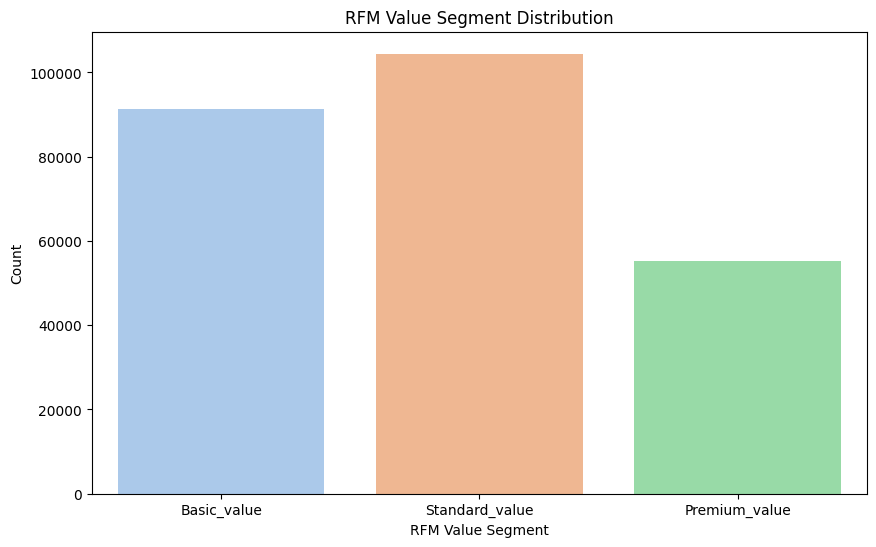

In [139]:
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(x='value_segment', y='Count', data=seg_counts, palette="pastel")

# Set labels and title
plt.xlabel('RFM Value Segment')
plt.ylabel('Count')
plt.title('RFM Value Segment Distribution')

# Show the plot
plt.show()

## RFM Customer Segments
* Provide a more strategic perspective on customer behaviour and characteristics in terms of recency, frequency, and monetary aspects.
* Its a broader classifications based on RFM scores.
* It represents the categorization of customers based on their RFM scores into groups such as “Basic value”, “Standard value”, and “Premium value”. These segments are determined by dividing RFM scores into distinct ranges or groups, allowing for a more granular analysis of overall customer RFM characteristics. The RFM value segment helps us understand the relative value of customers in terms of recency, frequency, and monetary aspects.

In [140]:
# Create a new column for RFM Customer Segments
rfm['RFM_customer_segments'] = ''

# Assign RFM segments based on the RFM score
rfm.loc[rfm['RFM_Score'] >= 9, 'RFM_customer_segments'] = 'Champions'
rfm.loc[(rfm['RFM_Score'] >= 7) & (rfm['RFM_Score'] < 9), 'RFM_customer_segments'] = 'Loyal Customers'
rfm.loc[(rfm['RFM_Score'] >= 5) & (rfm['RFM_Score'] < 7), 'RFM_customer_segments'] = 'Moderate Customers' 
rfm.loc[(rfm['RFM_Score'] >= 3) & (rfm['RFM_Score'] < 5), 'RFM_customer_segments'] = 'Inactive Customers' 


In [141]:
# Print the updated data with RFM segments
print(rfm[['customer_id', 'RFM_customer_segments']])

       customer_id RFM_customer_segments
0           u16446             Champions
1           u12346    Moderate Customers
2           u15098       Loyal Customers
3           u15749    Moderate Customers
4           u15749    Moderate Customers
...            ...                   ...
251239      u15858             Champions
251240       u1592    Inactive Customers
251241      u13952       Loyal Customers
251242      u15618    Moderate Customers
251243      u16198    Moderate Customers

[251244 rows x 2 columns]


In [142]:
# To determine the range of RFM scores associated with each customer segment label.
RFM_ranges = rfm.groupby('RFM_customer_segments')['RFM_Score'].agg(['min', 'max'])
print(RFM_ranges)

                       min  max
RFM_customer_segments          
Champions                9   12
Inactive Customers       3    4
Loyal Customers          7    8
Moderate Customers       5    6


###### RFM_customer_segments
- Champions: lie in the range of RFM score between 9 to 12
- Loyal Customers: lie in the range of RFM score between 7 to 8
- Moderate Customers: lie in the range of RFM score between 5 to 6
- Inactive Customers: lie between in the range of RFM score between 3 to 4    

In [143]:
rfm.head(10)

customer_id  recency  frequency       monetary  r_score  f_score  m_score   
0      u16446        0          3  168472.500000        4        1        4  \
1      u12346      325          1   77183.600000        1        1        4   
2      u15098      182          1   13305.500000        2        1        4   
3      u15749      235          5   22267.150000        1        1        4   
4      u15749      235          5   22267.150000        1        1        4   
5      u15749      235          5   22267.150000        1        1        4   
6      u15195        2          1    3861.000000        4        1        4   
7      u17949      134         28   22362.956000        2        1        4   
8      u15749      235          5   22267.150000        1        1        4   
9      u18102       49        145   80559.168766        3        3        4   

   RFM_Score   value_segment RFM_customer_segments  
0          9  Standard_value             Champions  
1          6     Basic_value    Moderate Customers  
2          7  Standard_value       Loyal Customers  
3          6     Basic_value    Moderate Customers  
4          6     Basic_value    Moderate Customers  
5          6     Basic_value    Moderate Customers  
6          9  Standard_value             Champions  
7          7  Standard_value       Loyal Customers  
8          6     Basic_value    Moderate Customers  
9         10   Premium_value             Champions

In [144]:
# Analyzing the distribution of customers across different RFM customer segments within each value segment:
segment_product_counts = rfm.groupby(['value_segment', 'RFM_customer_segments']).size().reset_index(name='Count')
segment_product_counts = segment_product_counts.sort_values('Count', ascending=False)

In [145]:
segment_product_counts

value_segment RFM_customer_segments  Count
6   Standard_value       Loyal Customers  68391
3      Basic_value    Moderate Customers  62144
8    Premium_value             Champions  55306
4   Standard_value             Champions  36099
1      Basic_value    Inactive Customers  29304
0      Basic_value             Champions      0
2      Basic_value       Loyal Customers      0
5   Standard_value    Inactive Customers      0
7   Standard_value    Moderate Customers      0
9    Premium_value    Inactive Customers      0
10   Premium_value       Loyal Customers      0
11   Premium_value    Moderate Customers      0

In [146]:
# Ploting treemap to classifying customer segment as per value segments Premium value, Standard value & Basic value
pio.templates.default = "plotly_white"
fig = px.treemap(segment_product_counts, path=['value_segment', 'RFM_customer_segments', 'Count'])
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

* This provided treemap segments customers based on their value into different categories. These interpretations highlight the    distribution of customer segments across value tiers, ranging from champions to moderate and inactive customers.

In [147]:
# Analyze the distribution of RFM values within the Champions segment:

In [148]:
# Filter the data to include only the customers in the Champions segment
champions_segment = rfm[rfm['RFM_customer_segments'] == 'Champions']

In [149]:
fig = go.Figure()
fig.add_trace(go.Box(y=champions_segment['r_score'], name='Recency'))
fig.add_trace(go.Box(y=champions_segment['f_score'], name='Frequency'))
fig.add_trace(go.Box(y=champions_segment['m_score'], name='Monetary'))

fig.update_layout(title='Distribution of RFM Values within Champions Segment',
                  yaxis_title='RFM Value',
                  showlegend=True)

fig.show()

* Recency: Distributed normally, suggests that these top customers consistently make recent purchases,indicating their ongoing engagement.
* Frequency: The distribution skewed above the median implies that Champions tend to make more frequent purchases than the average customer, indicating strong loyalty and repeat business.
* Monetary: Similarly, the distribution above the median for monetary value signifies higher spending among Champions, contributing to increased revenue generation.

In [150]:
# Analyze the correlation of the recency, frequency, and monetary scores within the champions segment

In [151]:
correlation_matrix = rfm[['r_score', 'f_score', 'm_score']].corr()

# Visualize the correlation matrix using a heatmap
fig_heatmap = go.Figure(data=go.Heatmap(
                   z=correlation_matrix.values,
                   x=correlation_matrix.columns,
                   y=correlation_matrix.columns,
                   colorscale='RdBu',
                   colorbar=dict(title='Correlation')))

fig_heatmap.update_layout(title='Correlation Matrix of RFM Values within Champions Segment')

fig_heatmap.show()

In [152]:
# Examine the number of customers in all the segments: 

In [153]:
segment_counts = rfm['RFM_customer_segments'].value_counts()
segment_counts

RFM_customer_segments
Champions             91405
Loyal Customers       68391
Moderate Customers    62144
Inactive Customers    29304
Name: count, dtype: int64

In [154]:
pastel_colors = plotly.colors.qualitative.Pastel

segment_counts = rfm['RFM_customer_segments'].value_counts()

# Create a bar chart to compare segment counts
fig = go.Figure(data=[go.Bar(x=segment_counts.index, y=segment_counts.values,
                            marker=dict(color=pastel_colors))])

# Set the color of the Champions segment as a different color
champions_color = 'rgb(158, 202, 225)'
fig.update_traces(marker_color=[champions_color if segment == 'Champions' else pastel_colors[i]
                                for i, segment in enumerate(segment_counts.index)],
                  marker_line_color='rgb(8, 48, 107)',
                  marker_line_width=1.5, opacity=0.6)

# Update the layout
fig.update_layout(title='Comparison of RFM Segments',
                  xaxis_title='RFM Segments',
                  yaxis_title='Number of Customers',
                  showlegend=False)

fig.show()

* Here's a brief interpretation:
- Champions: Largest group of highly engaged and valuable customers. Focus on retaining them through exclusive rewards and        personalized experiences.
- Loyal Customers: Significant group showing consistent loyalty. Maintain their engagement with consistent value and    incentives.
- Moderate Customers: Moderate spending group. Increase average order value with bundle deals and upselling. Tailor communication                     to encourage repeat purchases.
- Inactive Customers: Small group of inactive customers. Use re-engagement campaigns and special offers to win them back.


In [155]:
# Explore the scores for recency, frequency, and monetary aspects across all segments.

In [156]:
segment_scores = rfm.groupby('RFM_customer_segments')[['r_score', 'f_score', 'm_score']].mean().reset_index()
segment_scores

RFM_customer_segments   r_score   f_score   m_score
0             Champions  3.017034  3.530179  3.484153
1    Inactive Customers  1.329272  1.116196  1.152948
2       Loyal Customers  2.498721  2.516691  2.506470
3    Moderate Customers  2.305259  1.605626  1.678988

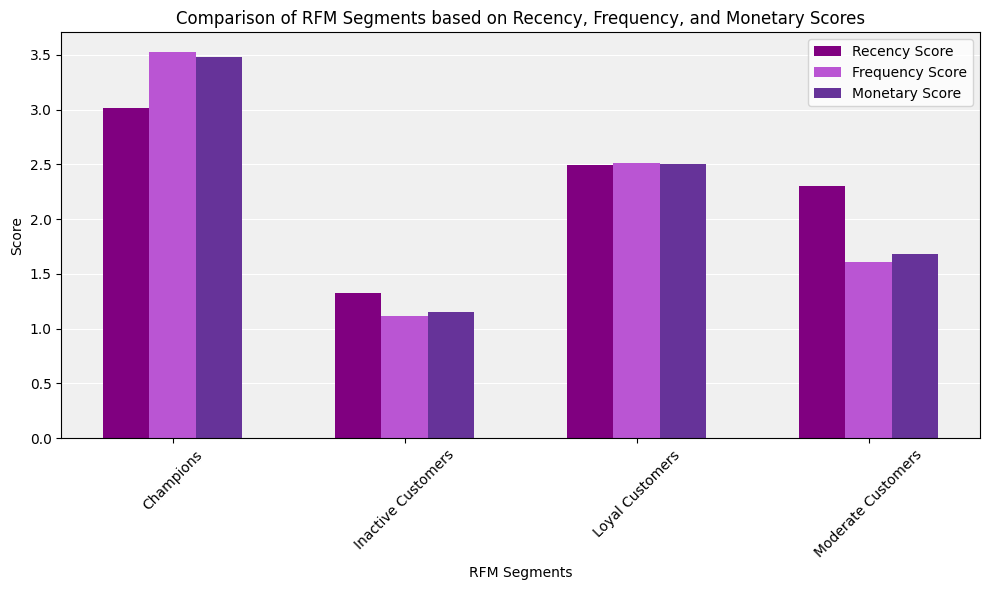

In [157]:
# Calculate the average Recency, Frequency, and Monetary scores for each segment
segment_scores = rfm.groupby('RFM_customer_segments')[['r_score', 'f_score', 'm_score']].mean().reset_index()

# Set up the figure and axes
plt.figure(figsize=(10, 6))
ax = plt.subplot()

# Bar width and positions
bar_width = 0.2
x = np.arange(len(segment_scores))

# Create bars for Recency score
rects1 = plt.bar(x - bar_width, segment_scores['r_score'], width=bar_width, label='Recency Score', color='purple')

# Create bars for Frequency score
rects2 = plt.bar(x, segment_scores['f_score'], width=bar_width, label='Frequency Score', color='mediumorchid')

# Create bars for Monetary score
rects3 = plt.bar(x + bar_width, segment_scores['m_score'], width=bar_width, label='Monetary Score', color='rebeccapurple')

# Set the x-axis labels
plt.xticks(x, segment_scores['RFM_customer_segments'], rotation=45)

# Set labels and title
plt.xlabel('RFM Segments')
plt.ylabel('Score')
plt.title('Comparison of RFM Segments based on Recency, Frequency, and Monetary Scores')

# Add legend
plt.legend()

# Customize the background color and grid
ax.set_facecolor('#f0f0f0')  # Light gray background
ax.yaxis.grid(color='white')  # Add white gridlines to y-axis background

# Ensure that gridlines are drawn below other elements
ax.set_axisbelow(True)


# Show the plot
plt.tight_layout()
plt.show()


* Overall, "Champions" are the most valuable segment due to their high recency, frequency, and monetary scores.
* "Inactive Customers" need re-engagement efforts, and "Moderate Customers" might benefit from strategies to increase their spending.

## Visualizing the customer segments

In [158]:
# The pie chart illustrates the distribution of customers across different segments based on the provided percentages.

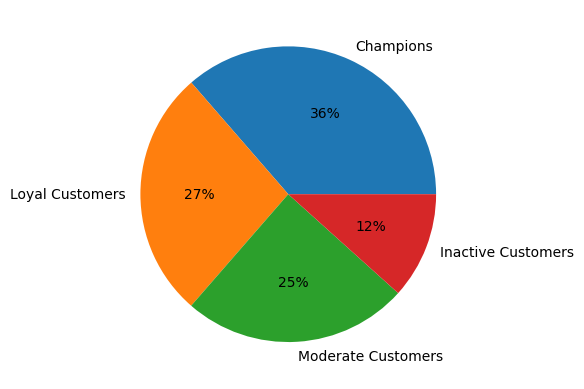

In [159]:
plt.pie(rfm.RFM_customer_segments.value_counts(),
        labels=rfm.RFM_customer_segments.value_counts().index,
        autopct='%.0f%%')
plt.show()


* The pie chart reveals insights:
-  This pie chart provides a visual representation of your customer distribution across different segments. It highlights the importance of the "Champions" and "Loyal Customers" segments as the primary revenue drivers, while also emphasizing the need to focus on the "Moderate Customers" and "Inactive Customers" segments to maximize engagement and revenue potential.

In [160]:
rfm.head(10)

customer_id  recency  frequency       monetary  r_score  f_score  m_score   
0      u16446        0          3  168472.500000        4        1        4  \
1      u12346      325          1   77183.600000        1        1        4   
2      u15098      182          1   13305.500000        2        1        4   
3      u15749      235          5   22267.150000        1        1        4   
4      u15749      235          5   22267.150000        1        1        4   
5      u15749      235          5   22267.150000        1        1        4   
6      u15195        2          1    3861.000000        4        1        4   
7      u17949      134         28   22362.956000        2        1        4   
8      u15749      235          5   22267.150000        1        1        4   
9      u18102       49        145   80559.168766        3        3        4   

   RFM_Score   value_segment RFM_customer_segments  
0          9  Standard_value             Champions  
1          6     Basic_value    Moderate Customers  
2          7  Standard_value       Loyal Customers  
3          6     Basic_value    Moderate Customers  
4          6     Basic_value    Moderate Customers  
5          6     Basic_value    Moderate Customers  
6          9  Standard_value             Champions  
7          7  Standard_value       Loyal Customers  
8          6     Basic_value    Moderate Customers  
9         10   Premium_value             Champions

In [161]:
customer_segmentation = rfm.groupby('customer_id').agg(
    value_segment=('value_segment', 'first'), # Assuming value_segment remains constant for each customer
    RFM_customer_segments=('RFM_customer_segments', 'first'),# Assuming RFM_customer_segments remains constant for each customer
    Rfm_Score =('RFM_Score','first') # Assuming RFM_Score remains constant for each customer
).reset_index()
customer_segmentation

customer_id   value_segment RFM_customer_segments  Rfm_Score
0         u12346     Basic_value    Moderate Customers          6
1         u12347     Basic_value    Moderate Customers          6
2         u12348     Basic_value    Moderate Customers          5
3         u12349  Standard_value             Champions          9
4          u1235     Basic_value    Inactive Customers          3
...          ...             ...                   ...        ...
4209       u1828     Basic_value    Inactive Customers          3
4210      u18281     Basic_value    Inactive Customers          4
4211      u18282     Basic_value    Moderate Customers          6
4212      u18283  Standard_value       Loyal Customers          8
4213      u18287  Standard_value       Loyal Customers          8

[4214 rows x 4 columns]

##### RFM value segmentation and RFM customer segmentation
* RFM value segmentation is about grouping customers based on their actual RFM scores, while RFM customer segmentation is about assigning meaningful labels to those scores to guide marketing and engagement strategies. Both approaches aim to improve customer understanding and engagement, but they emphasize different aspects of the RFM framework.

#### 6. What conclusions can you draw about the customers of this online gifts platform? Ideally you want to come up with several segments of customers - your most important customers, customers that need enticing back to purchase and your regular and dependable customers.


* Key Takeaways from Customer Segmentation:
    1. Diverse Engagement: In the Basic Value Segment, Loyal and Moderate Customers contribute significantly, indicating a range of engagement levels and spending patterns.
    2. Strong Champions: Both Standard and Premium Value Segments boast a substantial number of Champion customers, suggesting a core group of highly engaged and high-spending individuals.
    3. Missing Loyalty: The absence of Loyal, Moderate, and Steady Customers in Standard and Premium segments might signify room for improvement in nurturing repeat business.
    4. Targeted Strategies: These insights allow for tailored marketing strategies to strengthen engagement, re-engage inactive customers, and enhance the loyalty of valuable segments.
        
* In conclusion, the customer segmentation reveals diverse engagement levels across value segments. Focus should be on leveraging the strong presence of Champions, re-engaging inactive customers, and optimizing strategies to cater to each segment's unique behaviors and preferences.

##### Overall Strategies:

* Cross-Selling and Upselling: Implement targeted cross-selling and upselling strategies for all value segments. Recommend related or complementary products to encourage customers to explore more items and increase their overall spending.

* Personalization: Leverage customer data to provide personalized recommendations, offers, and shopping experiences tailored to each segment's preferences and behaviors.

* Retention Programs: Develop retention programs specific to each value segment. Offer loyalty rewards, early access to sales, and exclusive content to keep customers engaged and coming back.

* Segment-Specific Campaigns: Create marketing campaigns that address the unique needs and interests of each segment. Tailor messaging, channels, and offers to resonate with their behaviors and motivations.

* Feedback and Engagement: Regularly gather feedback from customers in each segment to understand their expectations and pain points. Use this feedback to refine your offerings and improve the overall customer experience.

* Key is to understand the characteristics and preferences of each customer segment and tailor the strategies to address their specific needs. By delivering value and exceptional experiences, it can encourage higher spending and foster long-term loyalty across all value segments.

## Loading Data to Local data folder

In [162]:
customer_segmentation.to_csv("../data/customer_segmentation_data.csv")

In [163]:
customer_segmentation= pd.read_csv('../data/customer_segmentation_data.csv')

In [164]:
customer_segmentation.head()

Unnamed: 0 customer_id   value_segment RFM_customer_segments  Rfm_Score
0           0      u12346     Basic_value    Moderate Customers          6
1           1      u12347     Basic_value    Moderate Customers          6
2           2      u12348     Basic_value    Moderate Customers          5
3           3      u12349  Standard_value             Champions          9
4           4       u1235     Basic_value    Inactive Customers          3

In [170]:
data_2011 = online_trans_cleaned[
    (online_trans_cleaned['invoice_date'].dt.year == 2011) & 
    (online_trans_cleaned['total_order_value'] > 0)
]

# Group the data by customer_id, country, and description
grouped_data = data_2011.groupby(['customer_id', 'country', 'description']).agg(
    total_transactions=pd.NamedAgg(column='invoice', aggfunc='nunique'),
    unique_product_count=pd.NamedAgg(column='stock_code', aggfunc='nunique'),
    recent_purchase_date=pd.NamedAgg(column='invoice_date', aggfunc='max'),
    avg_order_value=pd.NamedAgg(column='total_order_value', aggfunc='mean')
).reset_index()

# Sort the data by avg_order_value in descending order
agg_data = grouped_data.sort_values(by='avg_order_value', ascending=False)

# Reset the index to get default integer index
agg_data.reset_index(drop=True, inplace=True)

# Calculate recency
agg_data["recency"]=round((agg_data['recent_purchase_date'].max() - agg_data['recent_purchase_date']) / np.timedelta64(1, 'D'),0)

# calculate Frequency
frequency_data = agg_data.groupby('customer_id')['total_transactions'].count().reset_index()
frequency_data.rename(columns={'total_transactions': 'frequency'}, inplace =True)
agg_data = agg_data.merge(frequency_data, on='customer_id', how='left')

# calculate Monetary
monetary_data = agg_data.groupby('customer_id')['avg_order_value'].sum().reset_index()
monetary_data.rename(columns={'avg_order_value': 'monetary'}, inplace=True)
agg_data= agg_data.merge(monetary_data, on='customer_id', how='left')

# Computing Quantile of RFM values
rfm['r_score'] = pd.qcut(rfm['recency'], 4, ['4','3','2','1'])
rfm['f_score'] = pd.qcut(rfm['frequency'], 4, ['1','2','3','4'])
rfm['m_score'] = pd.qcut(rfm['monetary'], 4, ['1','2','3','4'])

# Convert RFM Score to numeric type
rfm['r_score'] = rfm['r_score'].astype(int)
rfm['f_score'] = rfm['f_score'].astype(int)
rfm['m_score'] = rfm['m_score'].astype(int)

# To calculate the RFM score, we add the scores obtained for recency, frequency and monetary value. 
rfm['RFM_Score'] = rfm['r_score']+rfm['f_score']+rfm['m_score']
rfm.head()


# Create RFM segments based on the RFM score
segment_labels = ['Basic_value', 'Standard_value', 'Premium_value']
rfm['value_segment'] = pd.qcut(rfm['RFM_Score'], q=3, labels=segment_labels)

# Create a new column for RFM Customer Segments
rfm['RFM_customer_segments'] = ''

# Assign RFM segments based on the RFM score
rfm.loc[rfm['RFM_Score'] >= 9, 'RFM_customer_segments'] = 'Champions'
rfm.loc[(rfm['RFM_Score'] >= 7) & (rfm['RFM_Score'] < 9), 'RFM_customer_segments'] = 'Loyal Customers'
rfm.loc[(rfm['RFM_Score'] >= 5) & (rfm['RFM_Score'] < 7), 'RFM_customer_segments'] = 'Moderate Customers' 
rfm.loc[(rfm['RFM_Score'] >= 3) & (rfm['RFM_Score'] < 5), 'RFM_customer_segments'] = 'Inactive Customers' 

customer_segmentation = rfm.groupby('customer_id').agg(
    value_segment=('value_segment', 'first'), # Assuming value_segment remains constant for each customer
    RFM_customer_segments=('RFM_customer_segments', 'first'),# Assuming RFM_customer_segments remains constant for each customer
    Rfm_Score =('RFM_Score','first') # Assuming RFM_Score remains constant for each customer
).reset_index()
customer_segmentation


customer_id   value_segment RFM_customer_segments  Rfm_Score
0         u12346     Basic_value    Moderate Customers          6
1         u12347     Basic_value    Moderate Customers          6
2         u12348     Basic_value    Moderate Customers          5
3         u12349  Standard_value             Champions          9
4          u1235     Basic_value    Inactive Customers          3
...          ...             ...                   ...        ...
4209       u1828     Basic_value    Inactive Customers          3
4210      u18281     Basic_value    Inactive Customers          4
4211      u18282     Basic_value    Moderate Customers          6
4212      u18283  Standard_value       Loyal Customers          8
4213      u18287  Standard_value       Loyal Customers          8

[4214 rows x 4 columns]

In [167]:
def load_and_prepare_data(online_trans_cleaned):
    data_2011_positive_avg = online_trans_cleaned[
        (online_trans_cleaned['invoice_date'].dt.year == 2011) &
        (online_trans_cleaned['total_order_value'] > 0)
    ]
    return data_2011

In [169]:
def group_data(data_2011):
    grouped_data = data.groupby(['customer_id', 'country', 'description']).agg(
        total_transactions=pd.NamedAgg(column='invoice', aggfunc='nunique'),
        unique_product_count=pd.NamedAgg(column='stock_code', aggfunc='nunique'),
        recent_purchase_date=pd.NamedAgg(column='invoice_date', aggfunc='max'),
        avg_order_value=pd.NamedAgg(column='total_order_value', aggfunc='mean')
    ).reset_index()
    agg_data = grouped_data.sort_values(by='avg_order_value', ascending=False)
    agg_data.reset_index(drop=True, inplace=True)

    return agg_data

In [ ]:
# Calculate recency function
def calculate_recency(agg_data):
    data["recency"] = round((data['recent_purchase_date'].max() - data['recent_purchase_date']) / np.timedelta64(1, 'D'), 0)
    
    return agg_data

In [ ]:
def calculate_and_merge_monetary(data, monetary_column='avg_order_value'):
      monetary_data = data.groupby('customer_id')[monetary_column].sum().reset_index()
    monetary_data.rename(columns={monetary_column: 'monetary'}, inplace=True)
    data = data.merge(monetary_data, on='customer_id', how='left')

    rfm = data[['customer_id', 'recency', 'frequency', 'monetary']]

    return rfm

In [ ]:
def calculate_rfm_metrics(agg_data):
    # Calculate recency
    agg_data["recency"] = round((agg_data['recent_purchase_date'].max() - agg_data['recent_purchase_date']) / np.timedelta64(1, 'D'), 0)

    # Calculate frequency
    frequency_data = agg_data.groupby('customer_id')['total_transactions'].count().reset_index()
    frequency_data.rename(columns={'total_transactions': 'frequency'}, inplace=True)
    agg_data = agg_data.merge(frequency_data, on='customer_id', how='left')

    # Calculate monetary
    monetary_data = agg_data.groupby('customer_id')['avg_order_value'].sum().reset_index()
    monetary_data.rename(columns={'avg_order_value': 'monetary'}, inplace=True)
    agg_data = agg_data.merge(monetary_data, on='customer_id', how='left')
    
     rfm = data[['customer_id', 'recency', 'frequency', 'monetary']]
    

    return rfm

In [ ]:


def calculate_rfm_segmentation(online_trans_cleaned, rfm):
    """
    Calculate RFM (Recency, Frequency, Monetary) segmentation for customer data.

    Parameters:
        online_trans_cleaned (DataFrame): Cleaned transaction data.
        rfm (DataFrame): DataFrame containing customer IDs and initial RFM data.

    Returns:
        DataFrame: Customer segmentation results.
    """
    # Filter data for the year 2011 and positive order values
    data_2011 = online_trans_cleaned[
        (online_trans_cleaned['invoice_date'].dt.year == 2011) & 
        (online_trans_cleaned['total_order_value'] > 0)
    ]

    # Group data by customer_id, country, and description
    grouped_data = data_2011.groupby(['customer_id', 'country', 'description']).agg(
        total_transactions=pd.NamedAgg(column='invoice', aggfunc='nunique'),
        unique_product_count=pd.NamedAgg(column='stock_code', aggfunc='nunique'),
        recent_purchase_date=pd.NamedAgg(column='invoice_date', aggfunc='max'),
        avg_order_value=pd.NamedAgg(column='total_order_value', aggfunc='mean')
    ).reset_index()

    # Sort the data by avg_order_value in descending order
    agg_data = grouped_data.sort_values(by='avg_order_value', ascending=False)

    # Reset the index to get default integer index
    agg_data.reset_index(drop=True, inplace=True)

    # Calculate recency
    agg_data["recency"] = round((agg_data['recent_purchase_date'].max() - agg_data['recent_purchase_date']) / np.timedelta64(1, 'D'), 0)

    # Calculate frequency
    frequency_data = agg_data.groupby('customer_id')['total_transactions'].count().reset_index()
    frequency_data.rename(columns={'total_transactions': 'frequency'}, inplace=True)
    agg_data = agg_data.merge(frequency_data, on='customer_id', how='left')

    # Calculate monetary
    monetary_data = agg_data.groupby('customer_id')['avg_order_value'].sum().reset_index()
    monetary_data.rename(columns={'avg_order_value': 'monetary'}, inplace=True)
    agg_data = agg_data.merge(monetary_data, on='customer_id', how='left')

    # Computing Quantile of RFM values
    rfm['r_score'] = pd.qcut(rfm['recency'], 4, ['4','3','2','1'])
    rfm['f_score'] = pd.qcut(rfm['frequency'], 4, ['1','2','3','4'])
    rfm['m_score'] = pd.qcut(rfm['monetary'], 4, ['1','2','3','4'])

    # Convert RFM Score to numeric type
    rfm['r_score'] = rfm['r_score'].astype(int)
    rfm['f_score'] = rfm['f_score'].astype(int)
    rfm['m_score'] = rfm['m_score'].astype(int)

    # To calculate the RFM score, we add the scores obtained for recency, frequency, and monetary value.
    rfm['RFM_Score'] = rfm['r_score'] + rfm['f_score'] + rfm['m_score']

    # Create RFM segments based on the RFM score
    segment_labels = ['Basic_value', 'Standard_value', 'Premium_value']
    rfm['value_segment'] = pd.qcut(rfm['RFM_Score'], q=3, labels=segment_labels)

    # Create a new column for RFM Customer Segments
    rfm['RFM_customer_segments'] = ''

    # Assign RFM segments based on the RFM score
    rfm.loc[rfm['RFM_Score'] >= 9, 'RFM_customer_segments'] = 'Champions'
    rfm.loc[(rfm['RFM_Score'] >= 7) & (rfm['RFM_Score'] < 9), 'RFM_customer_segments'] = 'Loyal Customers'
    rfm.loc[(rfm['RFM_Score'] >= 5) & (rfm['RFM_Score'] < 7), 'RFM_customer_segments'] = 'Moderate Customers' 
    rfm.loc[(rfm['RFM_Score'] >= 3) & (rfm['RFM_Score'] < 5), 'RFM_customer_segments'] = 'Inactive Customers' 

    # Group by customer_id and select relevant columns
    customer_segmentation = rfm.groupby('customer_id').agg(
        value_segment=('value_segment', 'first'),
        RFM_customer_segments=('RFM_customer_segments', 'first'),
        Rfm_Score=('RFM_Score', 'first')
    ).reset_index()

    return customer_segmentation